Bootstraping

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
file_path = "../county_election_results.csv"
df_elecciones = pd.read_csv(file_path)

In [3]:
votos_totales = df_elecciones["votes_total_2020"]
votos_objetivo = df_elecciones["votes_R_2020"]
porcentage_votos = votos_objetivo / votos_totales * 100

In [5]:
def distribucion_acumulativa_empirica(data):
    sorted_data = np.sort(data)
    n = len(data)
    y = np.arange(1, n+1) / n
    return sorted_data, y

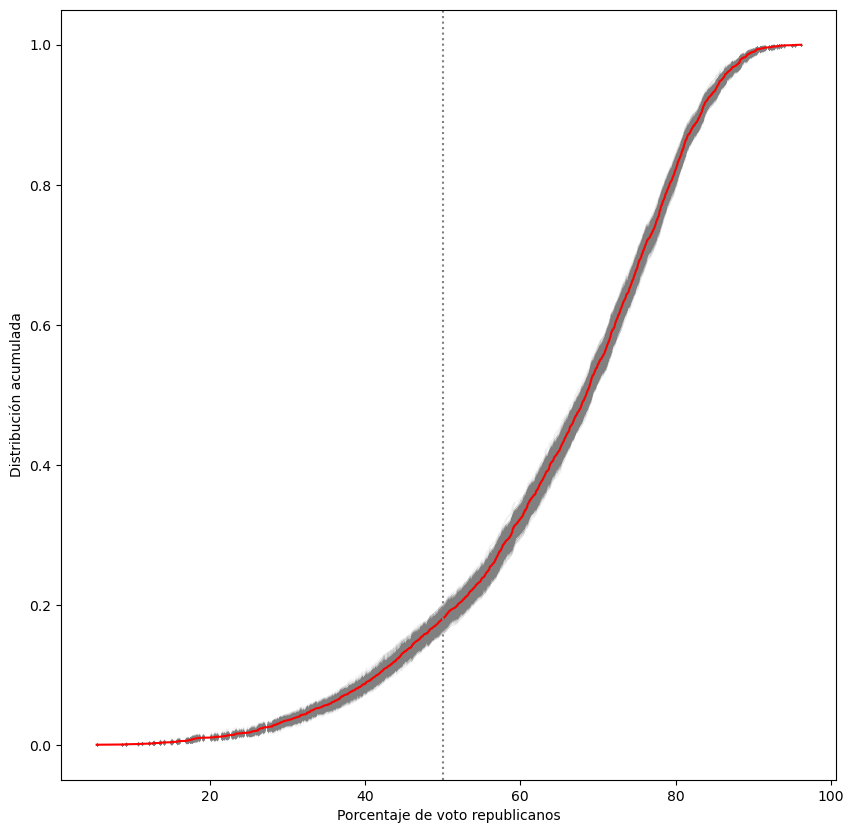

In [7]:

nsamples = 1000
xb = porcentage_votos
plt.figure(figsize=(10, 10))

for ns in range(nsamples):
    bs_sample = np.random.choice(xb, size=len(xb))
    x, y = distribucion_acumulativa_empirica(bs_sample)
    _ = plt.plot(
        x, y, marker=".", markersize=0.2, linestyle="none", color="gray", alpha=0.1
    )


x, y = distribucion_acumulativa_empirica(xb)
_ = plt.plot(x, y, "-", color="red")


plt.xlabel("Porcentaje de voto republicanos")
plt.ylabel("Distribución acumulada")
plt.axvline(x=50, ls=":", color="gray")

## Bootstraping no paramétrico

0.8200514138817481
IC (95%): [0.80751125 0.83387693]


(0.0, 110.0)

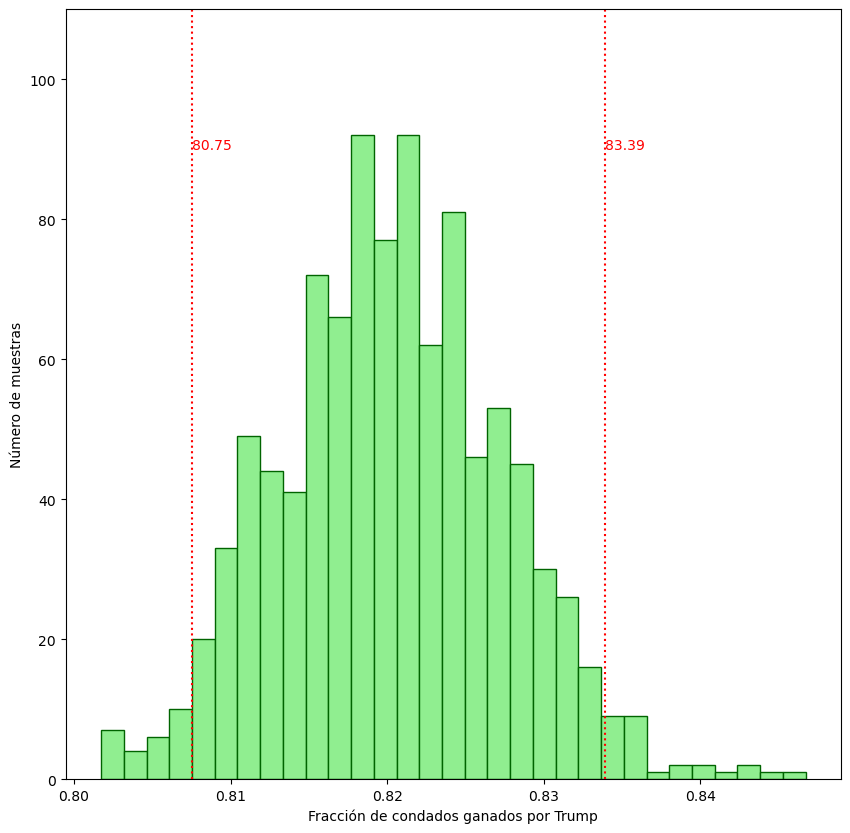

In [10]:

nsamples = 1000
xb = porcentage_votos

# estadistica promedio para los datos
counties_D = xb[xb >= 50.0]
frac_D = len(counties_D) / len(df_elecciones)
print(frac_D)
plt.figure(figsize=(10, 10))

frac_D_b = np.empty(nsamples)
for ns in range(nsamples):
    bs_sample = np.random.choice(xb, size=len(xb))
    counties_D_b = bs_sample[bs_sample >= 50.0]
    frac_D_b[ns] = len(counties_D_b) / len(bs_sample)


_ = plt.hist(frac_D_b, bins=int(np.sqrt(nsamples)), ec="darkgreen", fc="lightgreen")


IC = np.percentile(frac_D_b, [2.5, 97.5])

print("IC (95%):", IC)

plt.xlabel("Fracción de condados ganados por Trump")
plt.ylabel('Número de muestras')
# plt.axvline(x=frac_D,ls='--',color='k')
plt.axvline(x=IC[0], ls=":", color="r")
plt.axvline(x=IC[1], ls=":", color="r")
plt.text(IC[0], 90, "%.2f" % (IC[0] * 100), color="r", fontsize=10)
plt.text(IC[1], 90, "%.2f" % (IC[1] * 100), color="r", fontsize=10)

# plt.fill_betweenx([0,110],0.14,IC[0],alpha=0.2,color='r')
# plt.fill_betweenx([0,110],IC[1],0.2,alpha=0.2,color='r')
plt.ylim(0, 110)

En este caso podemos asegurar con un intervalo de confianza IC del 95% de que si se realizase una nueva elección Trump obtendría una victoria entre el 80.75% y el 83.39% de los condados.

In [12]:
swing = ["PA", "OH", "FL"]
df_elecciones["porcentage_votos_objetivo"] = porcentage_votos
dat_swing = df_elecciones[df_elecciones["state"].isin(swing)]


aqui estamos obteniendo la distribucion de los coeficientes a y b en ax+b para un conjunto de muestras, los histogramas nos van a indicar en cuantas muestras generadas por el bootstrapping los coeficientes a y b van variando. Practicamente con bootstrapping estamos obteniendo los coeficientes a y b de las regresiones lineales de cada una de nuestra smuestras generadas.

a: IC (95%): [-0.06583537 -0.04039086]
b: IC (95%): [68.99032717 72.12429832]


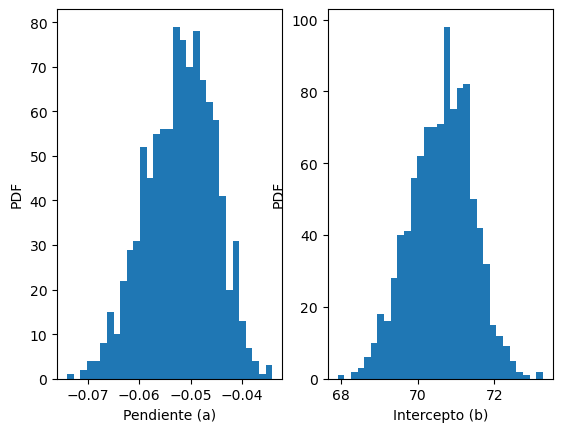

In [16]:
x = dat_swing["votes_total_2020"] / 1000
y = dat_swing["porcentage_votos_objetivo"]
x = x.to_numpy()
y = y.to_numpy()

# Indices
inds = np.arange(len(x))

# numero de muestras
size = 1000

# Initializar replicas: bs_slope_reps, bs_intercept_reps
#Coeficiente a en ax+b
bs_slope_reps = np.empty(size)
#Coeficiente b en ax+b
bs_intercept_reps = np.empty(size)

# Generar replicates
for i in range(size):
    bs_inds = np.random.choice(inds, size=len(inds))
    bs_x, bs_y = x[bs_inds], y[bs_inds]
    bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

print("a: IC (95%):", np.percentile(bs_slope_reps, [2.5, 97.5]))
print("b: IC (95%):", np.percentile(bs_intercept_reps, [2.5, 97.5]))

# Plot the histogram

f, (ax1, ax2) = plt.subplots(1, 2)

nbins = int(np.sqrt(size))
ax1.hist(bs_slope_reps, bins=nbins)
ax1.set_xlabel("Pendiente (a)")
ax1.set_ylabel("PDF")

ax2.hist(bs_intercept_reps, bins=nbins)
ax2.set_xlabel("Intercepto (b)")
ax2.set_ylabel("PDF")

plt.show()

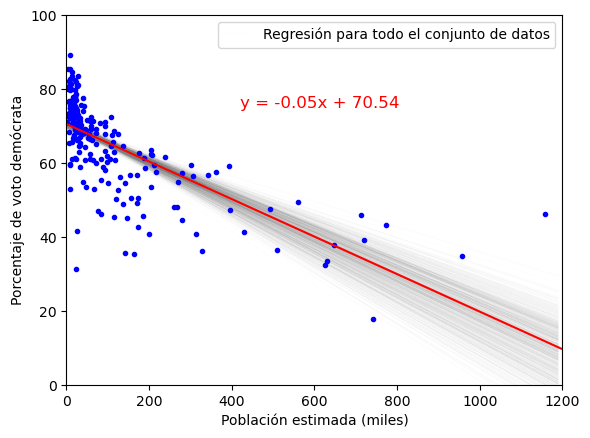

In [17]:
# Dibujar líneas de regresión con diferentes valores de pendiente e intersección
xf = np.arange(0, 1200, 10)
for a, b in zip(bs_slope_reps, bs_intercept_reps):
    plt.plot(xf, a * xf + b, lw=0.1, alpha=0.1, color="gray")

# Dibujar puntos originales
plt.plot(x, y, ".", color="blue")

# Calcular y dibujar la línea de regresión para todo el conjunto de datos
p = np.polyfit(x, y, 1)
xf = np.linspace(0, 1200, 100)
yf = np.polyval(p, xf)
plt.plot(xf, yf, "-", color="red")

# Ajustar los ejes y agregar etiquetas
plt.ylim(0, 100)
plt.xlim(0, 1200)
plt.xlabel("Población estimada (miles)")
plt.ylabel("Porcentaje de voto republicano")

# Agregar leyenda
plt.legend(["Regresión para todo el conjunto de datos"])

# Imprimir los coeficientes de la recta de regresión para todo el conjunto de datos
eq_text = "y = {:.2f}x + {:.2f}".format(p[0], p[1])
plt.text(420, 75, eq_text, fontsize=12, color="red")

plt.show()

aquí dibujamos todas las lineas de regresion de las muestras generadas por el bootstrapping

## Testeo de hipótesis

Primero establecemos una hipótesis nula.

En este caso estamos viendo la correlación que existe entre 2 estados con respecto al voto republicano.
Esta hipótesis nula puede ser que viendo el gráfico decimos de que la distribución entre estos 2 estados es la misma.

MI, media:59.67, mediana:62.10, std:9.66, len:83
WI, media:56.51, mediana:58.59, std:10.29, len:72
Diferencia en media: 3.17
Diferencia en mediana: 3.52
Diferencia en desviación estándar: 0.63


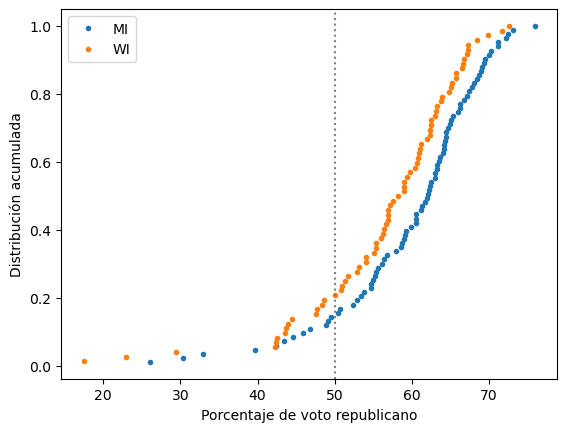

In [19]:

test = ["MI", "WI"]

for state in test:
    dats = df_elecciones[df_elecciones["state"] == state]
    x, y = distribucion_acumulativa_empirica(dats["porcentage_votos_objetivo"])
    plt.plot(x, y, marker=".", ls="none", label=state)
    plt.legend()

    print(
        "%s, media:%.2f, mediana:%.2f, std:%.2f, len:%.d"
        % (
            state,
            dats["porcentage_votos_objetivo"].mean(),
            dats["porcentage_votos_objetivo"].median(),
            dats["porcentage_votos_objetivo"].std(),
            len(dats["porcentage_votos_objetivo"]),
        )
    )

mi_dats = df_elecciones[df_elecciones["state"] == "MI"]
wi_dats = df_elecciones[df_elecciones["state"] == "WI"]

diff_mean = (
    mi_dats["porcentage_votos_objetivo"].mean()
    - wi_dats["porcentage_votos_objetivo"].mean()
)
diff_median = (
    mi_dats["porcentage_votos_objetivo"].median()
    - wi_dats["porcentage_votos_objetivo"].median()
)
diff_std = (
    mi_dats["porcentage_votos_objetivo"].std()
    - wi_dats["porcentage_votos_objetivo"].std()
)

print("Diferencia en media: %.2f" % abs(diff_mean))
print("Diferencia en mediana: %.2f" % abs(diff_median))
print("Diferencia en desviación estándar: %.2f" % abs(diff_std))

plt.xlabel("Porcentaje de voto republicano")
plt.ylabel("Distribución acumulada")
plt.axvline(x=50, ls=":", color="gray")

Ahora aplicamos permutación para reordenar los datos y que sean indistinguibles.

In [20]:
def permutation_sample(data1, data2):

    # datos concatenados
    data = np.concatenate((data1, data2))

    # permutacion
    permuted_data = np.random.permutation(data)

    # muestras permutadas
    perm_sample_1 = permuted_data[: len(data1)]
    perm_sample_2 = permuted_data[len(data2) :]

    return perm_sample_1, perm_sample_2

83 72


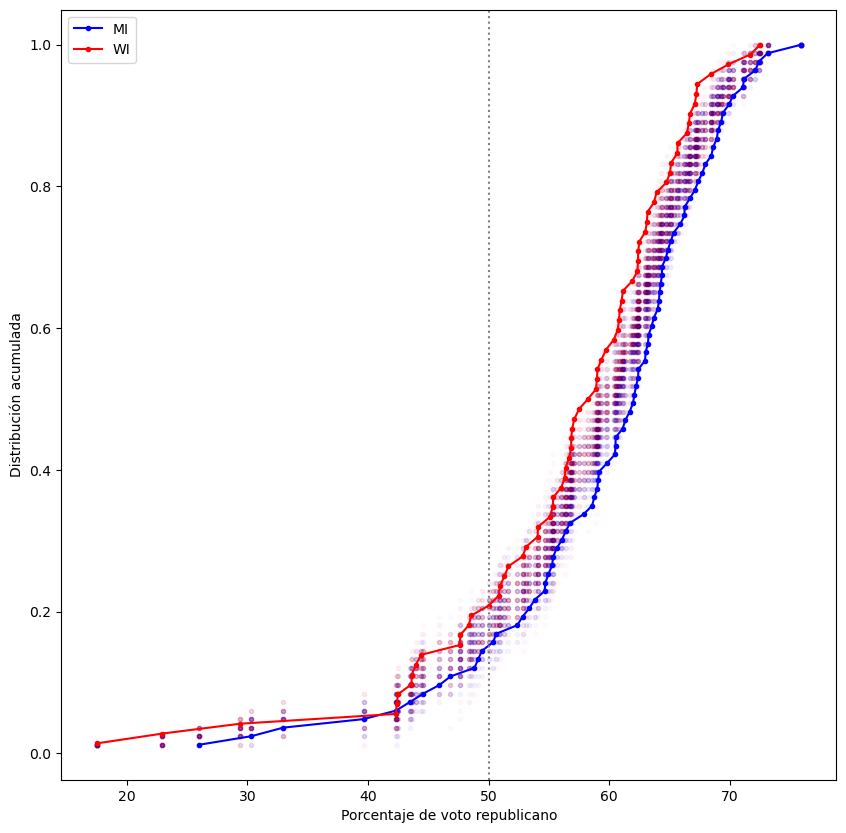

In [23]:

# datos por estado
pct_R_MI = df_elecciones[df_elecciones["state"] == "MI"]["porcentage_votos_objetivo"]
pct_R_WI = df_elecciones[df_elecciones["state"] == "WI"]["porcentage_votos_objetivo"]
print(len(pct_R_MI), len(pct_R_WI))
# generamos n permutaciones
nperm = 100
plt.figure(figsize=(10, 10))
for n in range(nperm):
    perm1, perm2 = permutation_sample(pct_R_MI, pct_R_WI)
    x, y = distribucion_acumulativa_empirica(perm1)
    plt.plot(x, y, marker=".", ls="none", color="blue", alpha=0.02)

    x, y = distribucion_acumulativa_empirica(perm2)
    plt.plot(x, y, marker=".", ls="none", color="red", alpha=0.02)

# graficamos las distribuciones originales de cada estado
x, y = distribucion_acumulativa_empirica(pct_R_MI)
plt.plot(x, y, marker=".", ls="-", label="MI", color="blue")

x, y = distribucion_acumulativa_empirica(pct_R_WI)
plt.plot(x, y, marker=".", ls="-", label="WI", color="red")
plt.legend()

plt.xlabel("Porcentaje de voto republicano")
plt.ylabel("Distribución acumulada")
plt.axvline(x=50, ls=":", color="gray")

Ahora debemos evaluar la hipótesis, usando una estadística de prueba.
Y usar el valor p para evaluar la hipótesis nula. Este valor nos indicará que tan probable sea que ocurra nuestra hipótesis nula. Para rechazarla debemos tene run valor p <0.05

In [24]:
def perm_reps(data_1, data_2, size=1):

    # Initializar arreglo dereplicas
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generar permutacion
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = perm_sample_1.mean() - perm_sample_2.mean()

    return perm_replicates

Diferencia promedio observada:-3.17
valor-p = 0.9703


Text(0, 0.5, 'N')

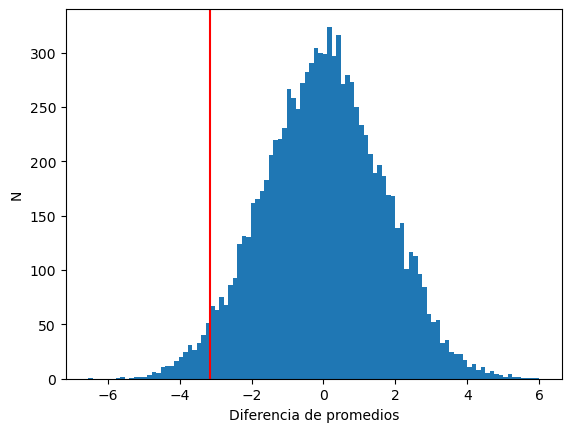

In [25]:

# observaciones (MI-WI)
obs_diff = pct_R_WI.mean() - pct_R_MI.mean()

print(r"Diferencia promedio observada:%.2f" % obs_diff)

# permutaciones
nperm = 10000
perm_replicates = perm_reps(pct_R_WI, pct_R_MI, size=nperm)

# valor-p
pval = np.sum(perm_replicates >= obs_diff) / len(perm_replicates)
print("valor-p =", pval)

_ = plt.hist(perm_replicates, bins=100)
_ = plt.axvline(x=obs_diff, color="r", label="Observed difference")
plt.xlabel("Diferencia de promedios")
plt.ylabel("N")

Esto me muestra en cuantas de mis 10000 permutaciones se observa una media mayor a la observada en la realidad. Por lo que podemos concluir que la hipótesis nula es verdadera, es decir que presentan una distribucion igual al voto republicano.